In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import subprocess
import ipywidgets as widgets
import pandas as pd
import make_csv
import BBN_Values as BBN_V
import os 
from scipy.interpolate import CubicSpline

The function below takes a mass file as an input as well as a file-name that you would like to be saved. It will be saved as a .npz file and should be the input to generate_2 and generate_3

In [2]:
def generate_1(filename,saved_file): 
    BBN_V.imp_values(filename,saved_file)

This function takes saved_file and generates all the CSV files. In order to make sure the function has ran correctly, go to downloads-->BBN_model-->alterbbn_v2.2-->CSVFiles. All the files here should have been updated seconds ago if the function is running correctly. 

In [3]:
def generate_2(saved_file):
    npz_data = np.load(saved_file)
    T = npz_data['T']
    dqdt = npz_data['dQdt']
    T_fit_dqdt = CubicSpline(T[::-1], dqdt[::-1])
    TT = np.logspace(-2,1,1000)
    
    derivative = np.diff(T_fit_dqdt(TT))/(np.diff(TT))
    q = np.where(derivative<0)[0]
    tran = q[-1]
    cutoff = TT[tran]
    
    make_csv.generate_csv(saved_file, folder_name="alterbbn_v2.2/CSVFiles/",T_dqdt_transition = cutoff)

This function takes saved_file as in input as well. It then runs the file alter_vs.c to generate a new evolution_vs.out file. In order to make sure this function has run correctly go to downloads-->BBN_models. The file called evolution_vs.out should have been updated seconds ago if the function was running correctly with no errors. 

In [4]:
def generate_3(saved_file):
    actual_data= np.load(saved_file, allow_pickle=True)
    T_init = actual_data['T_initial']
    eta_init = actual_data['eta_initial']
    fail_safe = actual_data['failsafe']
    ns_init = actual_data['ns_0']
    m_s = actual_data['vs_mass']
    mix = actual_data['mix_ang']
    row = actual_data['row']
    
    eta_0 = 6.1*10**-10
    a_0 = actual_data['scale'][0]
    a_f = actual_data['scale'][-1]
    T_f = actual_data['T'][-1]
    eta_in = (((eta_0))*(a_0*T_init)**3/((a_f*T_f)**3)*(11/4))
    
    
    subprocess.run(['./alterbbn_v2.2/alter_vs.x', str(T_init),str(eta_in),str(fail_safe),str(row),str(ns_init),str(m_s),str(mix)], capture_output = True, text = False)

generates diagnostics as a test 

In [5]:
def generate_4(filename,saved_file,evolution_file):
    actual_data= np.load(filename, allow_pickle=True)
    f_array = actual_data['fe']
    e_array = actual_data['e']
    temp_cm = actual_data['Tcm']
    m_s = actual_data['mass']#in MeV
    t = actual_data['time']*1000*6.582*10**-25#conversion to seconds for plots 
    a = actual_data['scalefactors']
    life = actual_data['lifetime']/(6.58*10**-25)*1/1000 #seconds need to be converted to inverse MeV
    temp = actual_data['temp'] #units of MeV
    decay = actual_data['decayrate']
    coll = actual_data['collisionrate']
    p_n = actual_data['p_n_rate']
    n_p = actual_data['n_p_rate']
    T_reversed = temp[::-1]

    
    more_data= np.load(saved_file, allow_pickle=True)
    p_e = more_data['pe_dens']
    p_e_reversed = p_e[::-1]

    
    time,scale,temperature,ETA,P_N,N_P = np.loadtxt(evolution_file,delimiter=',',skiprows=1,usecols=(0,1,2,20,21,22),unpack=True)
    all_data = np.loadtxt(evolution_file,delimiter=',',skiprows=1,unpack=True)
    
    #in all plots the dahsed are loaded from the mass file, while the solid are loaded from evolution_vs.out
    
    plt.figure()
    plt.loglog(time,(scale*temperature)/(scale[0]*temperature[0]),color='red')
    plt.loglog(t,(a*temp)/(a[0]*temp[0]),color='red',linestyle='--')
    plt.show()
    
    plt.figure()
    plt.loglog(t,p_n,color='red',linestyle='--')
    plt.loglog(time,P_N,color='red')
    plt.show()
    
    plt.figure()
    plt.loglog(t,n_p,color='red',linestyle='--')
    plt.loglog(time,N_P,color='red')
    plt.show()
    
    return all_data

This function allows us to created the processed mass file where we calculate various energy densities and dQ/dt. First input is the location of the mass files. Second input is the name of the name_indicator. A saved file will be created and name_indicator will be the word at the start of beginning of the mass file. This file with name_indicator at the beginning is the processed mass file. 

In [6]:
def process_npz(m_location,name_indicator):
    folder_contents = os.listdir(m_location)
    npz_files = [item for item in folder_contents if item.endswith(".npz")]
    for npz_file in npz_files:
        generate_1(f"../RMFK_Results/{npz_file}",f"{name_indicator}-{npz_file}")
        

In [7]:
process_npz("../RMFK_Results/","processed")

/Users/charmquark/Downloads/BBN_models/BBN_Values.py:21: RuntimeWarning: overflow encountered in exp
  integrand[i, j] = (zeta[j]**2 * np.sqrt(zeta[j]**2 + (m_e / T)**2)) / (np.exp(np.sqrt(zeta[j]**2 + (m_e / T)**2)) + 1) * np.exp(zeta[j])


Allows us get BBN abundances for various mass files. Takes same inputs as the previous function, but it also requires the location of the processed mass files. Both sets of files may not be in the same location. Returns some diagnostic plots.

In [8]:
def BBN_Abundances(m_location,p_m_location,name_indicator,BBN_abun_indicator):
    o_folder_contents = os.listdir(m_location)
    npz_files = [item for item in o_folder_contents if item.endswith(".npz")]
    npz_files.sort()
    
    folder_contents = os.listdir(p_m_location)
    processed_m_files = [item for item in folder_contents if item.startswith(f"{name_indicator}")]
    processed_m_files.sort()
    
    
    for i in range(len(processed_m_files)):
        p_m_file = processed_m_files[i]
        npz_file = npz_files[i]

        generate_2(f"{p_m_file}")
        generate_3(f"{p_m_file}")

        BBNA = generate_4(f"{m_location}/{npz_file}", f"{p_m_file}", "evolution_vs.out") #array of arrays.Correspond to a particular mass file
        eta_final = BBNA[20][-1]
        print(f"diagnostic graphs for {npz_file} above")
        print(f"final eta value from evolution_vs.out is {eta_final}")
        np.savez(f"{BBN_abun_indicator}-{npz_file}",BBN_abun = BBNA)

Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


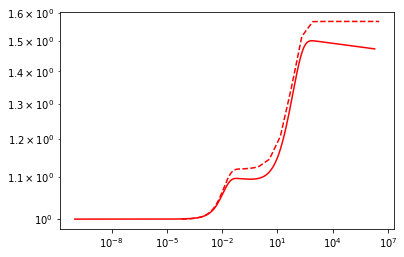

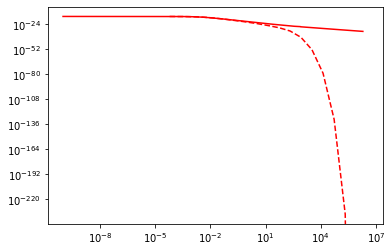

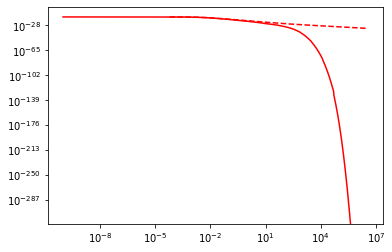

diagnostic graphs for mass-300-life-0.010.npz above
final eta value from evolution_vs.out is 3.24471e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


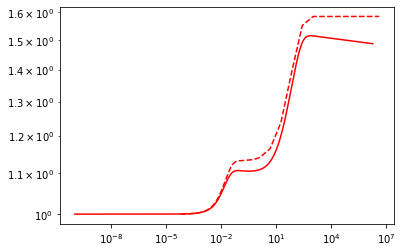

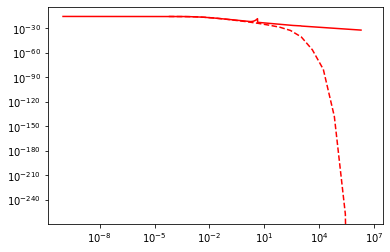

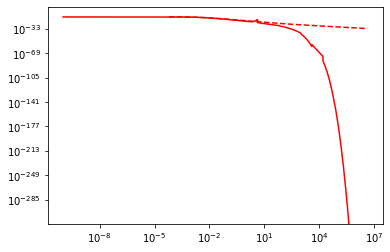

diagnostic graphs for mass-300-life-0.013.npz above
final eta value from evolution_vs.out is 3.06165e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


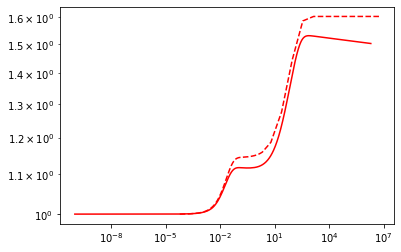

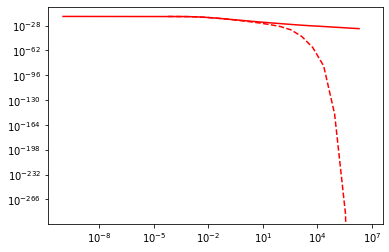

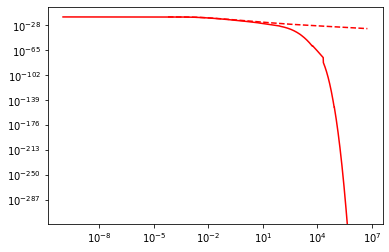

diagnostic graphs for mass-300-life-0.017.npz above
final eta value from evolution_vs.out is 2.87733e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


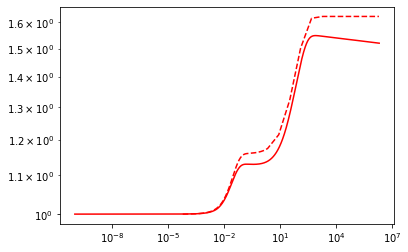

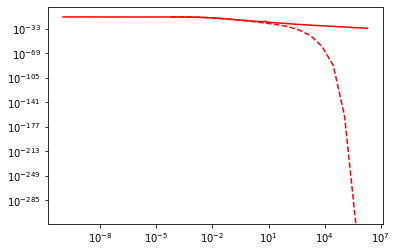

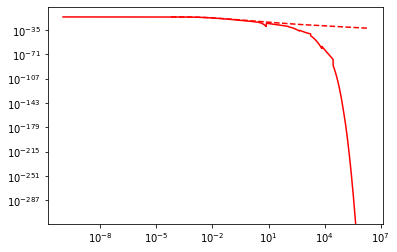

diagnostic graphs for mass-300-life-0.022.npz above
final eta value from evolution_vs.out is 2.66915e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


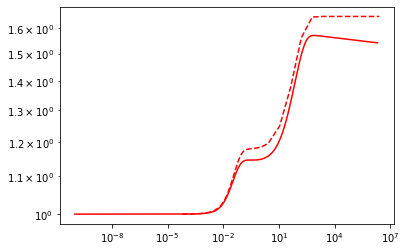

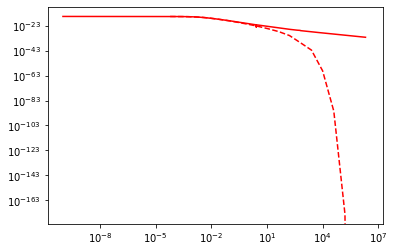

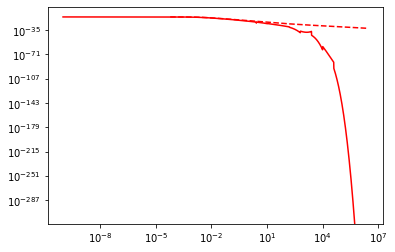

diagnostic graphs for mass-300-life-0.030.npz above
final eta value from evolution_vs.out is 2.43712e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


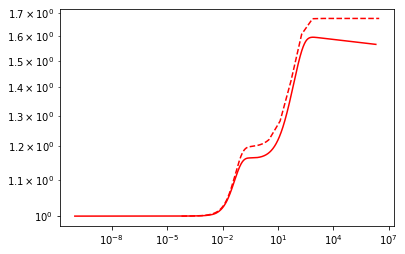

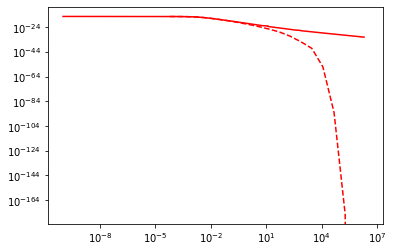

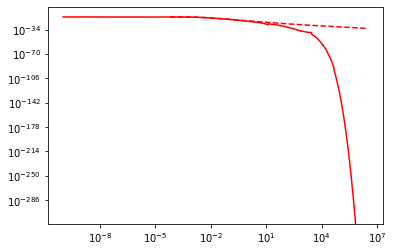

diagnostic graphs for mass-300-life-0.040.npz above
final eta value from evolution_vs.out is 2.21032e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


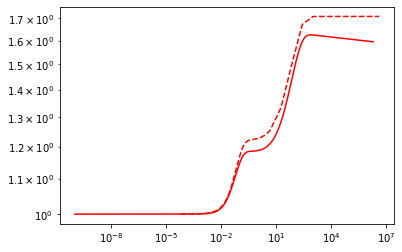

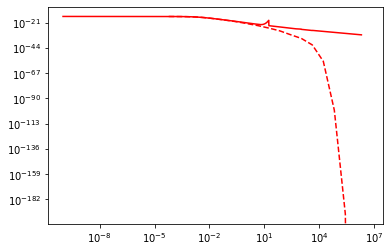

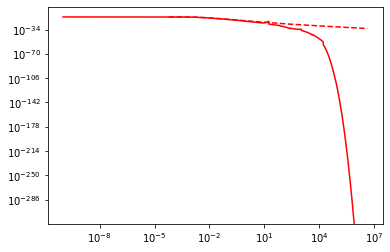

diagnostic graphs for mass-300-life-0.053.npz above
final eta value from evolution_vs.out is 1.97429e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


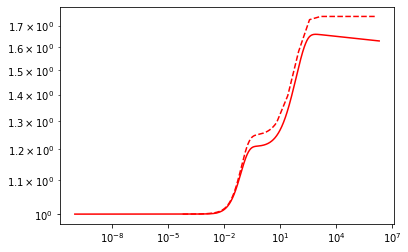

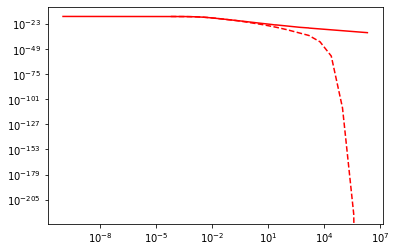

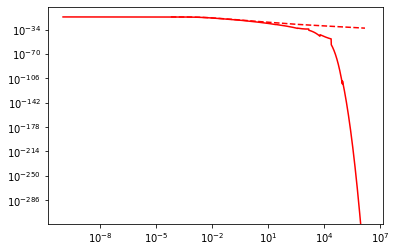

diagnostic graphs for mass-300-life-0.070.npz above
final eta value from evolution_vs.out is 1.73738e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


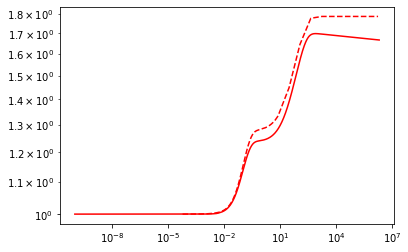

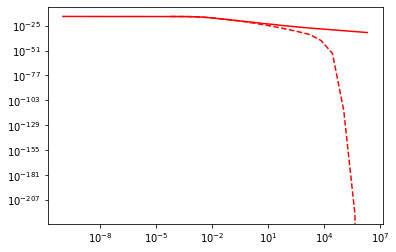

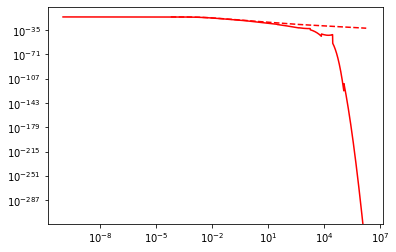

diagnostic graphs for mass-300-life-0.093.npz above
final eta value from evolution_vs.out is 1.5102e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


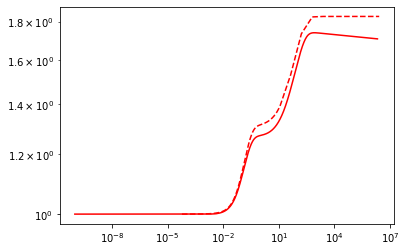

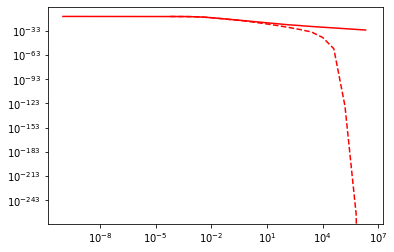

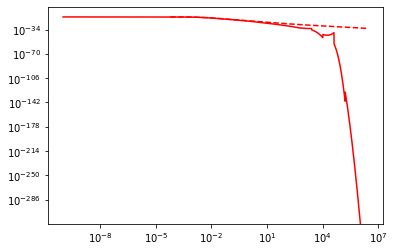

diagnostic graphs for mass-300-life-0.122.npz above
final eta value from evolution_vs.out is 1.30288e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


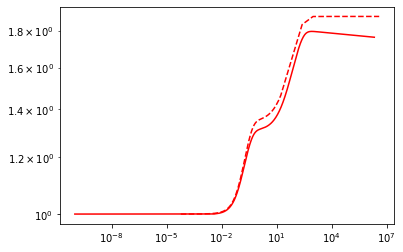

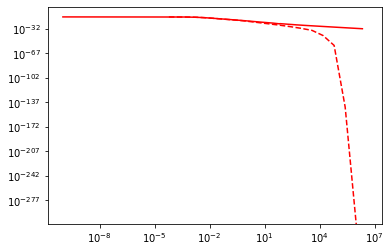

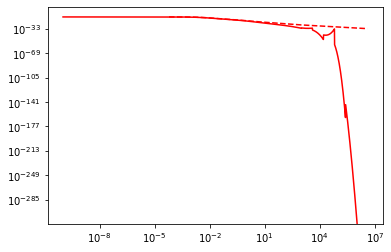

diagnostic graphs for mass-300-life-0.166.npz above
final eta value from evolution_vs.out is 1.08187e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


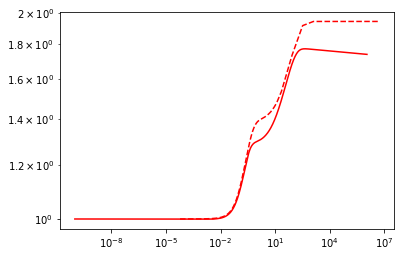

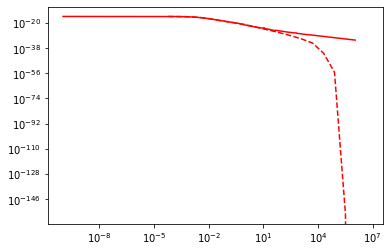

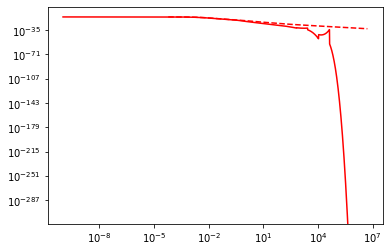

diagnostic graphs for mass-300-life-0.221.npz above
final eta value from evolution_vs.out is 1.03564e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


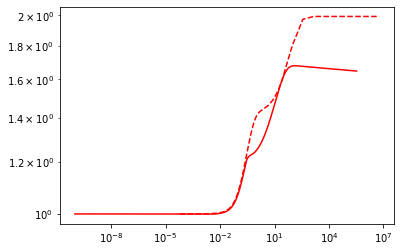

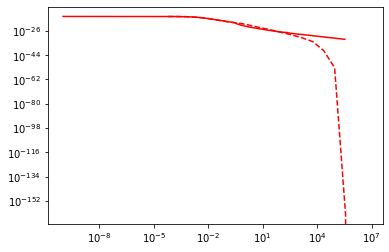

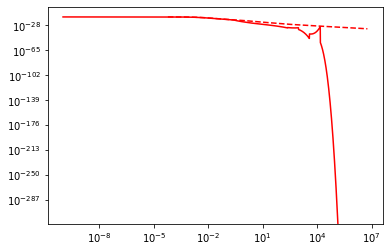

diagnostic graphs for mass-300-life-0.282.npz above
final eta value from evolution_vs.out is 1.12974e-10
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


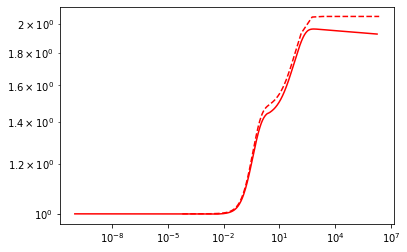

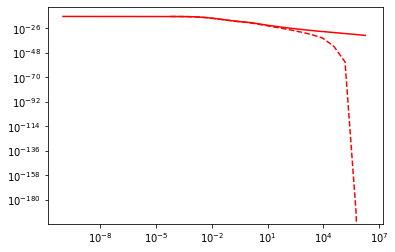

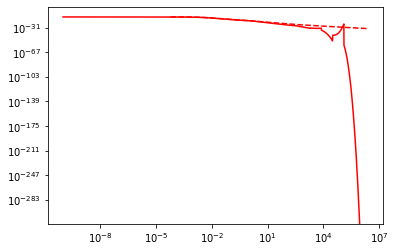

diagnostic graphs for mass-300-life-0.373.npz above
final eta value from evolution_vs.out is 6.39917e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


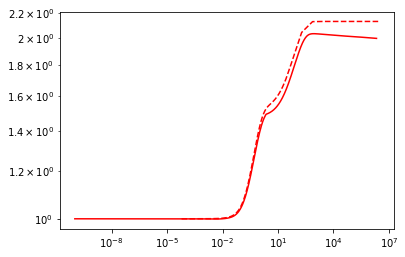

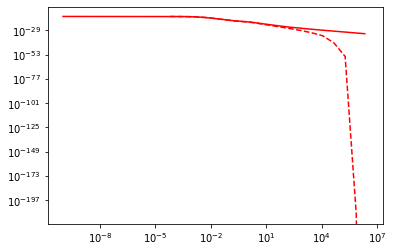

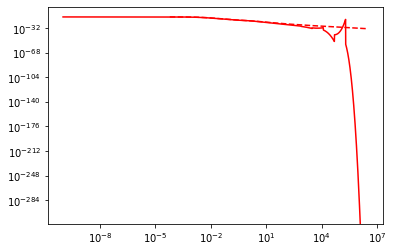

diagnostic graphs for mass-300-life-0.517.npz above
final eta value from evolution_vs.out is 5.15964e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


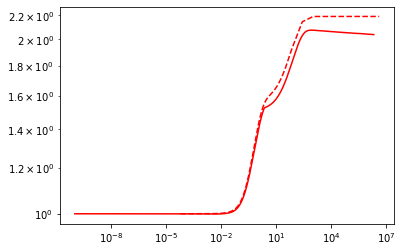

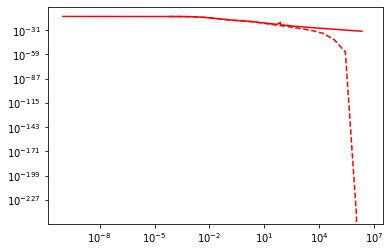

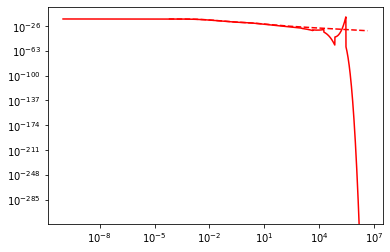

diagnostic graphs for mass-300-life-0.664.npz above
final eta value from evolution_vs.out is 4.44486e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


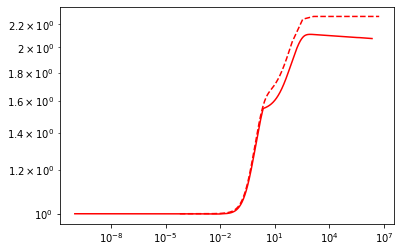

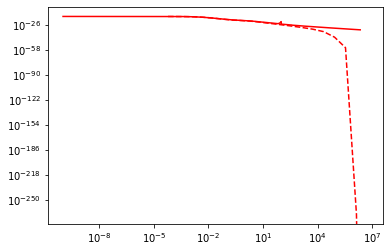

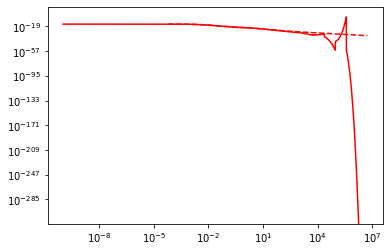

diagnostic graphs for mass-300-life-0.912.npz above
final eta value from evolution_vs.out is 3.7852e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


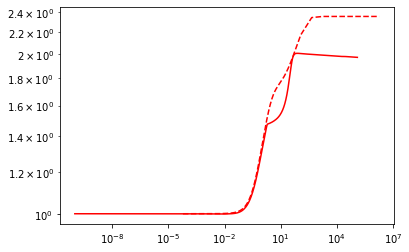

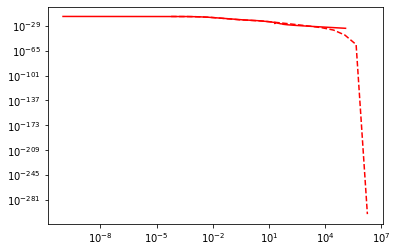

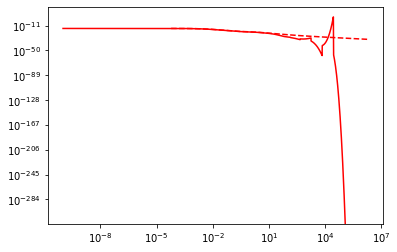

diagnostic graphs for mass-300-life-1.236.npz above
final eta value from evolution_vs.out is 3.94397e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


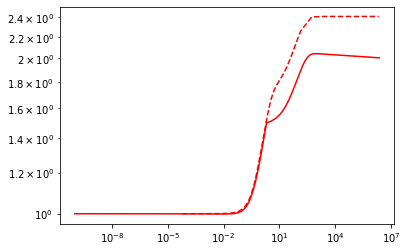

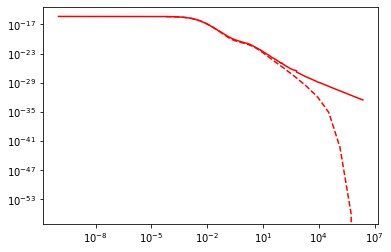

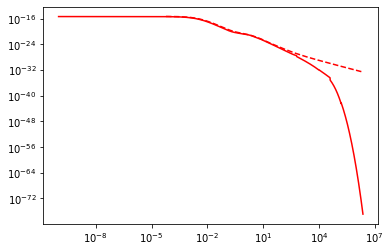

diagnostic graphs for mass-300-life-1.495.npz above
final eta value from evolution_vs.out is 3.5022e-11
Directory exists
.csv files generated in alterbbn_v2.2/CSVFiles/


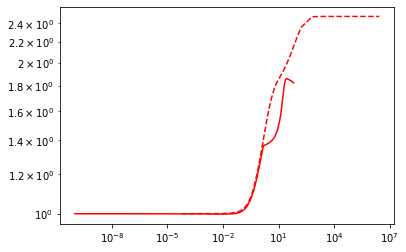

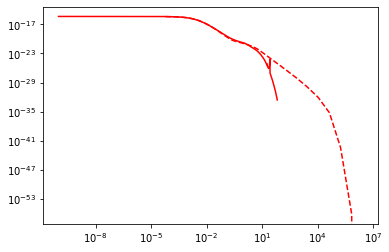

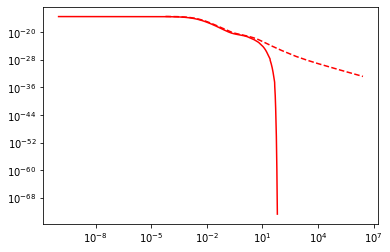

diagnostic graphs for mass-300-life-1.846.npz above
final eta value from evolution_vs.out is 4.30932e-11


In [9]:
BBN_Abundances("../RMFK_Results","../BBN_models/","processed","BBN-Abundances")

In [10]:
def element_plots(BBN_abun_location,m_location,BBN_abun_indicator):
    
    folder_contents = os.listdir(f"{BBN_abun_location}")
    BBN_files = [item for item in folder_contents if item.startswith(f"{BBN_abun_indicator}")]
    BBN_files.sort()

    more_folder_contents = os.listdir(f"{m_location}")
    m_files = [item for item in more_folder_contents if item.endswith(".npz")]
    m_files.sort()


    H2_final = []
    H3_final = []
    He_3_final = []
    He_4_final = []
    Li_6_final = []
    Li_7_final = []
    Be_7_final = []
    lifetimes = []
    for i in range(len(BBN_files)):
        BBN_file = BBN_files[i]
        m_file = m_files[i]
        data_act = np.load(f"{BBN_abun_location}/{BBN_file}", allow_pickle=True)
        more_data = np.load(f"{m_location}/{m_file}",allow_pickle=True)
    
        life = more_data['lifetime']
        lifetimes.append(life)
        value = data_act['BBN_abun']
    
        H2 = value[13][-1]
        H2_final.append(H2)
    
        H3 = value[14][-1]
        H3_final.append(H3)
    
        He3 = value[15][-1]
        He_3_final.append(He3)
    
        He4 = value[16][-1]
        He_4_final.append(He4)
    
        Li6 = value[17][-1]
        Li_6_final.append(Li6)
    
        Li7 = value[18][-1]
        Li_7_final.append(Li7)
    
        Be7 = value[19][-1]
        Be_7_final.append(Be7)
    
    Be_7_array = np.array(Be_7_final)
    Li_7_array = np.array(Li_7_final)
    
    plt.figure()
    plt.loglog(lifetimes,H2_final,color='red')
    plt.show()
    
    
    plt.figure()
    plt.loglog(lifetimes,Li_7_final,color='purple')
    plt.loglog(lifetimes,Be_7_final,color='black')
    plt.show()
    
    
    plt.figure()
    plt.loglog(lifetimes,Be_7_array+Li_7_array,color='black')
    plt.show()

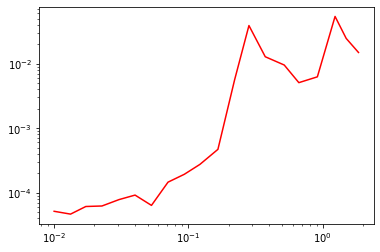

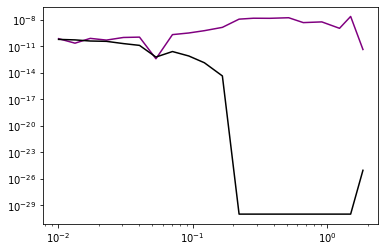

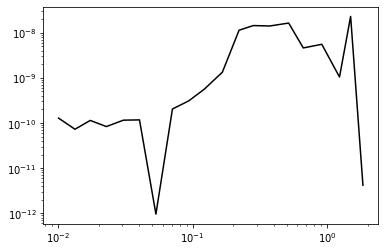

In [11]:
element_plots("../BBN_models","../RMFK_Results/","BBN-Abundances")